## some new decoding analyses... 

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from v1dd_public import ARTIFACT_DIR
import seaborn as sns

In [29]:
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mouse_colors_2 = {409828: "#66CCEE", 416296: "#228833", 427836: '#CCBB44', 438833: '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = [409828, 416296, 427836, 438833]
mouse_mapping = {
    '409828': 'Mouse 1',
    '416296': 'Mouse 2',
    '427836': 'Mouse 3',
    '438833': 'Mouse 4'
}

stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed", 
    "natural_images",
    "natural_images_12", 
    ]
decode_dims = {
    "drifting_gratings_full": "direction",
    "drifting_gratings_windowed": "direction",
    "natural_images": "image_index",
    "natural_images_12": "image_index",
               }

multi_stim_pairs = {
        "drifting_gratings_full": "drifting_gratings_windowed",
        "drifting_gratings_windowed": "drifting_gratings_full",
        "natural_images": "natural_images_12",
        "natural_images_12": "natural_images",
    }

chance = {
    "drifting_gratings_full": 1/12, 
    "drifting_gratings_windowed": 1/12, 
    "natural_images": 1/118,
    "natural_images_12": 1/12,
    }

def depth_vol_mapping(vol_id, plane_id):
    plane_list = [int(p) for p in list(str(plane_id))]
    plane_index = int(np.mean(plane_list) - 1) # plane index is 0-based, so subtract 1
    depth_values = {
                1: [50, 66, 82, 98, 114, 130],
                2: [146, 162, 178, 194, 210, 226],
                3: [242, 258, 274, 290, 306, 322],
                4: [338, 354, 370, 386, 402, 418],
                5: [434, 450, 466, 482, 498, 514],
                6: [500],
                7: [525],
                8: [550],
                9: [575],
                'a': [600],
                'b': [625],
                'c': [650],
                'd': [675],
                'e': [700],
                'f': [725]
            }
    return depth_values[vol_id][plane_index]

### 1. if the same subset of images in NS1 can be decoded if train/test is just NS1

### 2. if the first 20% of trials in NS2 is decodable

### 3. if "time" or trial number is decodable from NS2

In [30]:
tag = "2025-09-17_1"
bootstrap_size = 1
repetitions = 1
num_planes = 1
all_results_df = pd.DataFrame()
for stim_type in stim_types:
    decode_dim = decode_dims[stim_type]
    other_stim_type = multi_stim_pairs[stim_type]

    path_name = f'/home/naomi/Desktop/data/decoding_results/{tag}_TRAIN{stim_type}_TEST{other_stim_type}_Boot{bootstrap_size}_Rep{repetitions}_NumPlanes{num_planes}'
    results_df = pd.DataFrame()
    for filename in os.listdir(path_name):
        f = os.path.join(path_name, filename)
        results_df = pd.concat([results_df, pd.read_pickle(f)])
    
    results_df['stim_type_training'] = stim_type
    results_df['stim_type_testing'] = other_stim_type
    results_df['decode_dim'] = decode_dim

    all_results_df = pd.concat([all_results_df, results_df], axis=0)

all_results_df['depth'] = all_results_df.apply(lambda x: depth_vol_mapping(vol_id = x['volume_id'], plane_id = x['plane_id']), axis=1)

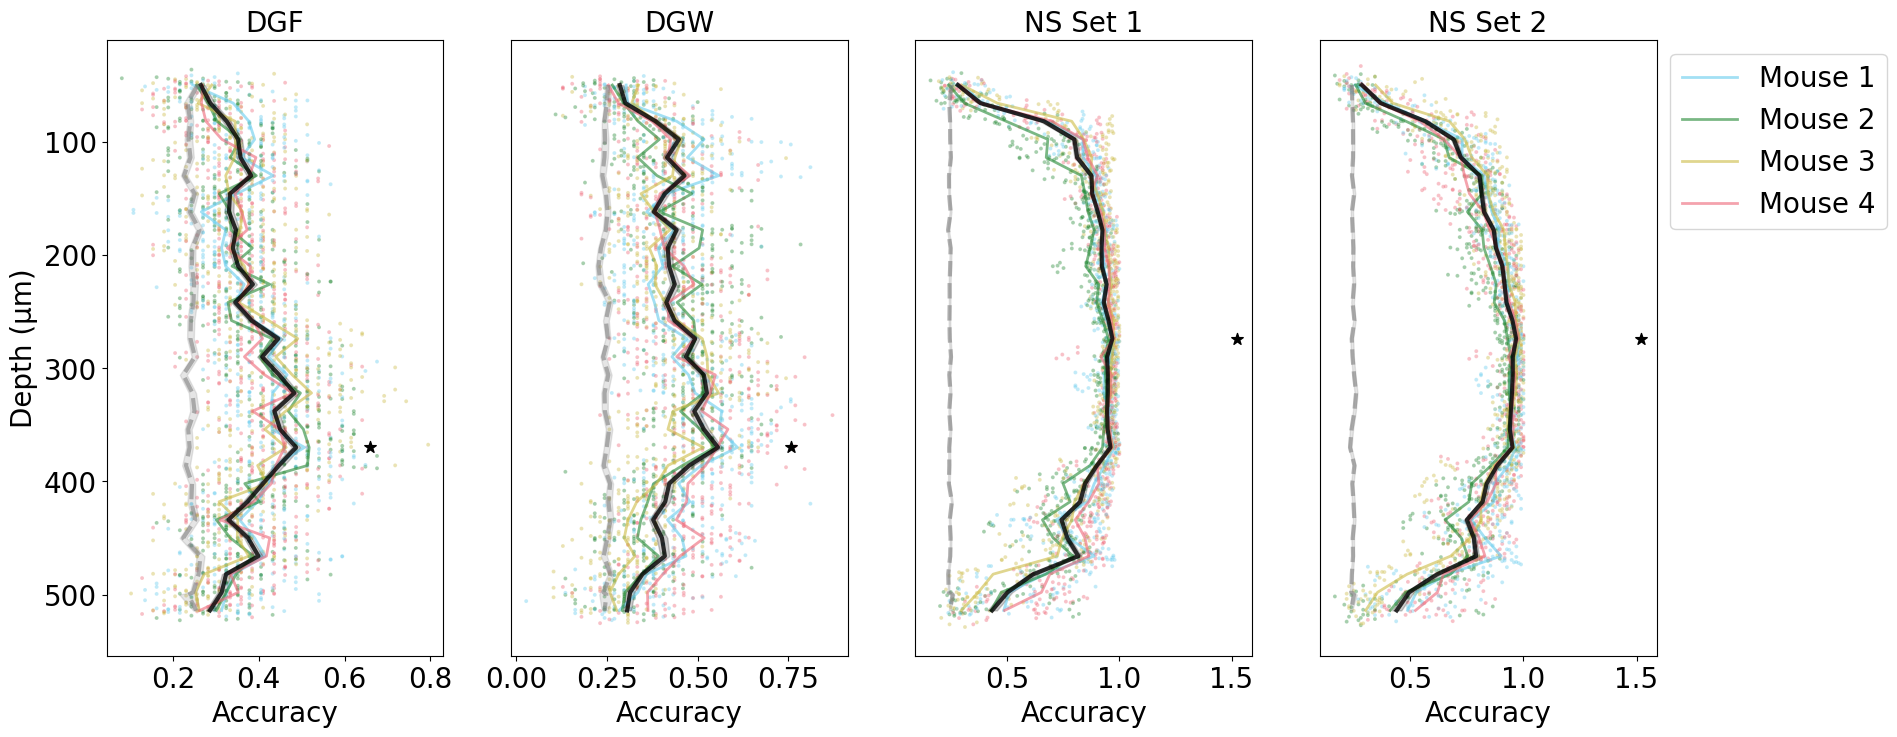

In [32]:
#### Plotting decoding accuracies for each mouse

# Some parameters for the plot
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
# titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
titles = {
    'drifting_gratings_full': 'DGF',
    'drifting_gratings_windowed': 'DGW',
    'natural_images': 'NS Set 1',
    'natural_images_12': 'NS Set 2'
}
n_stims = 4
jitter_amount = 5

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for stim_idx, stim_type in enumerate(stim_types):
    ax = axs[stim_idx]

    temp_df = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514) & (all_results_df['depth'] != 500)]
    temp_df = temp_df.explode('val_accuracy')
    # temp_df['val_accuracy'] = temp_df['val_accuracy'] / chance[stim_type]

    sns.lineplot(
        data=temp_df,
        x='val_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False if stim_idx != 3 else True,
    )

    ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
        loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if stim_idx == 3 else None

    sns.lineplot(data=temp_df, 
        x='val_accuracy', 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['val_accuracy'].mean().reset_index()
    sub_array = sub_df['val_accuracy'].values
    axs[stim_idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
        color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
        x='val_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        s=8,
        alpha=0.4,
        ax=ax,
        legend=False,
        zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df_shuf = temp_df_shuf.explode('shuf_val_accuracy')
    # temp_df_shuf['shuf_val_accuracy'] = temp_df_shuf['shuf_val_accuracy'] / chance[stim_type]
    
    sns.lineplot(data=temp_df_shuf, 
        x='shuf_val_accuracy', 
        y='depth', 
        color='grey', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linestyle='--',
        linewidth=3, 
        alpha=0.6, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    ax.set_title(titles[stim_type], fontsize=fontsize)
    ax.set_xlabel('Accuracy', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else ax.set_ylabel(" ")
    ax.set_yticks([]) if stim_idx != 0 else None
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    # ax.set_xlim(left=0, right=0.8) if stim_idx != 2 else ax.set_xlim(left=0, right=0.25)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

# plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG2D_nobootstrapping_1plane_valaccuracies_decoding.svg'), dpi=300)

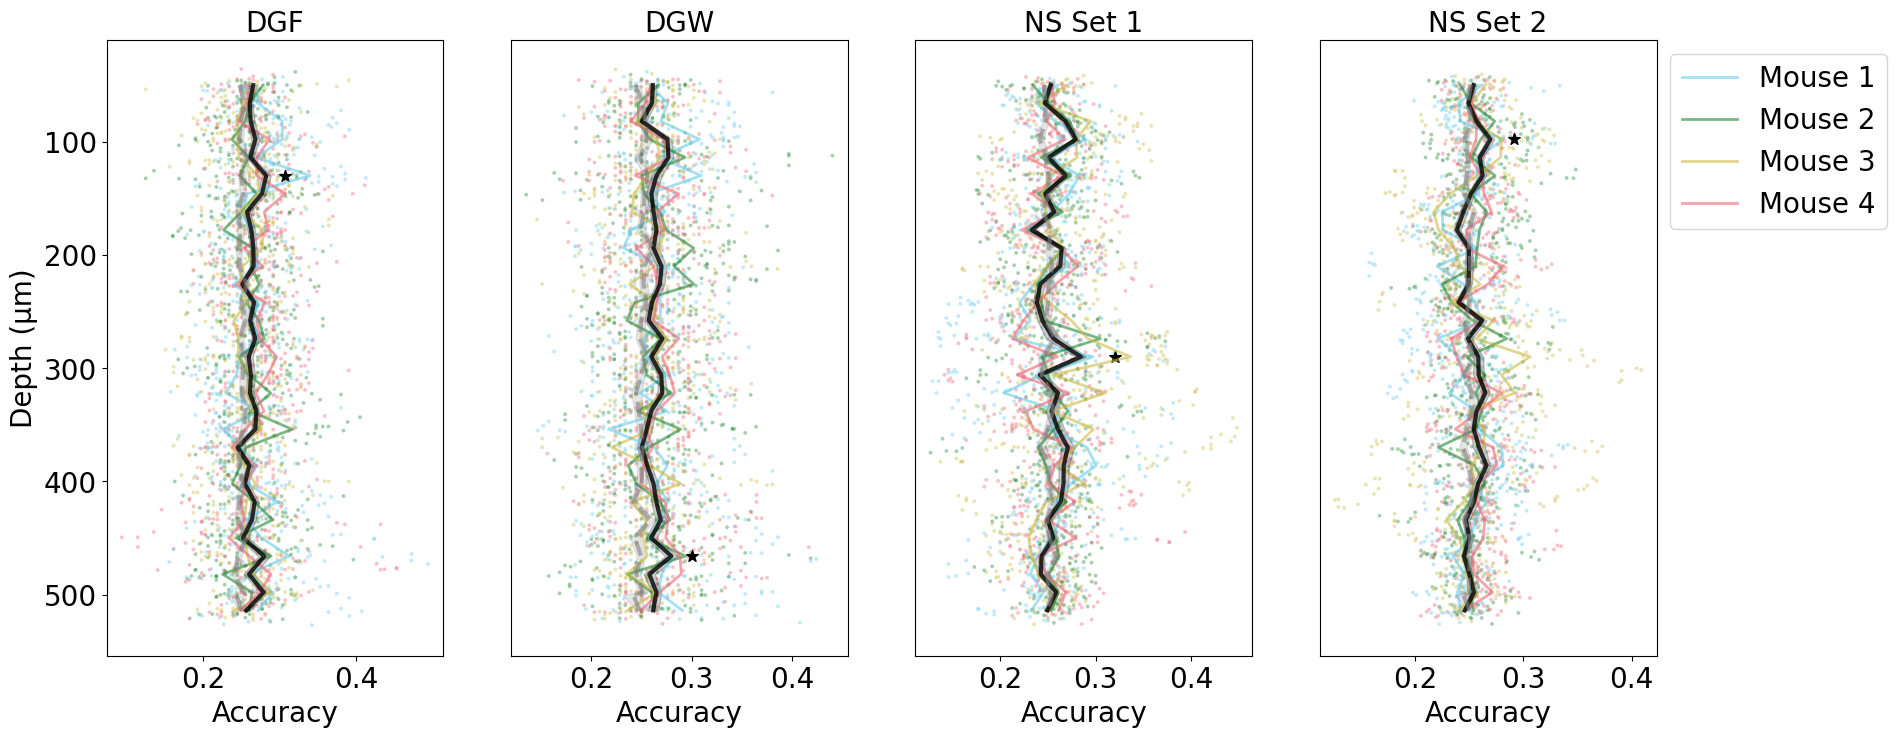

In [36]:
#### Plotting decoding accuracies for each mouse

# Some parameters for the plot
z_values = all_results_df['depth'].unique()
z_values = [z_val for z_val in z_values if z_val < 515]  # Filter out depths greater than 514
z_values = np.array(z_values)
z_values = np.sort(z_values)
# titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2']
titles = {
    'drifting_gratings_full': 'DGF',
    'drifting_gratings_windowed': 'DGW',
    'natural_images': 'NS Set 1',
    'natural_images_12': 'NS Set 2'
}
n_stims = 4
jitter_amount = 5

fig, axs = plt.subplots(1, n_stims, figsize=(20, 8))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for stim_idx, stim_type in enumerate(stim_types):
    ax = axs[stim_idx]

    temp_df = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514) & (all_results_df['depth'] != 500)]
    temp_df = temp_df.explode('test_accuracy')
    # temp_df['test_accuracy'] = temp_df['test_accuracy'] / chance[stim_type]

    sns.lineplot(
        data=temp_df,
        x='test_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False if stim_idx != 3 else True,
    )

    ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
        loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if stim_idx == 3 else None

    sns.lineplot(data=temp_df, 
        x='test_accuracy', 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    sub_df = temp_df.groupby('depth')['test_accuracy'].mean().reset_index()
    sub_array = sub_df['test_accuracy'].values
    axs[stim_idx].scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
        color='black', marker='*', s=75, edgecolor='black', zorder=1)
    
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, jitter_amount, size=len(temp_df))

    sns.scatterplot(data=temp_df,
        x='test_accuracy',
        y='depth',
        hue='mouse_id',
        palette=mouse_colors_2,
        s=8,
        alpha=0.4,
        ax=ax,
        legend=False,
        zorder=0,
    )

    # Add shuffled data line
    temp_df_shuf = all_results_df[(all_results_df['stim_type_training'] == stim_type) & (all_results_df['depth'] <= 514)]
    temp_df_shuf = temp_df_shuf.explode('shuf_test_accuracy')
    # temp_df_shuf['shuf_test_accuracy'] = temp_df_shuf['shuf_test_accuracy'] / chance[stim_type]
    
    sns.lineplot(data=temp_df_shuf, 
        x='shuf_test_accuracy', 
        y='depth', 
        color='grey', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linestyle='--',
        linewidth=3, 
        alpha=0.6, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    ax.set_title(titles[stim_type], fontsize=fontsize)
    ax.set_xlabel('Accuracy', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else ax.set_ylabel(" ")
    ax.set_yticks([]) if stim_idx != 0 else None
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    # ax.set_xlim(left=0, right=0.8) if stim_idx != 2 else ax.set_xlim(left=0, right=0.25)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

# plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG2D_nobootstrapping_1plane_valaccuracies_decoding.svg'), dpi=300)

In [33]:
import sys, os
sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import run_decoding
from allen_v1dd.client import OPhysClient
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from v1dd_public import ARTIFACT_DIR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns

In [34]:
# Set up the client and load the session
mouse_id = 'M427836'
col_vol_str = '25'
plane = 6
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

# Get the X and Y data for decoding -- x_data is the dff traces and y_data is the stimulus direction
x_data = run_decoding.get_X_data(session, plane, "drifting_gratings_full") # T x N
y_data = run_decoding.get_Y_data(session, plane, "drifting_gratings_full", 'time', 4) # T x 1

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Perform k-NN classification with hyperparameter tuning
param_grid = {'n_neighbors': list(range(1, 30))}
knn = KNeighborsClassifier(metric='correlation')
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_k_HIGH = grid_search.best_params_['n_neighbors']

# Fit the best model
knn = KNeighborsClassifier(n_neighbors=best_k_HIGH, metric='correlation')
knn.fit(x_train, y_train)

# Predict on training and test data
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)

# Calculate accuracy
print('HIGH PERFORMANCE EXAMPLE')
print(f"Training accuracy: {metrics.accuracy_score(y_train, y_pred_train)}")
print(f"Test accuracy: {metrics.accuracy_score(y_test, y_pred_test)}")

HIGH PERFORMANCE EXAMPLE
Training accuracy: 0.49019607843137253
Test accuracy: 0.15384615384615385


Text(0.5, 1.0, 'Confusion Matrix for Natural Images Decoding')

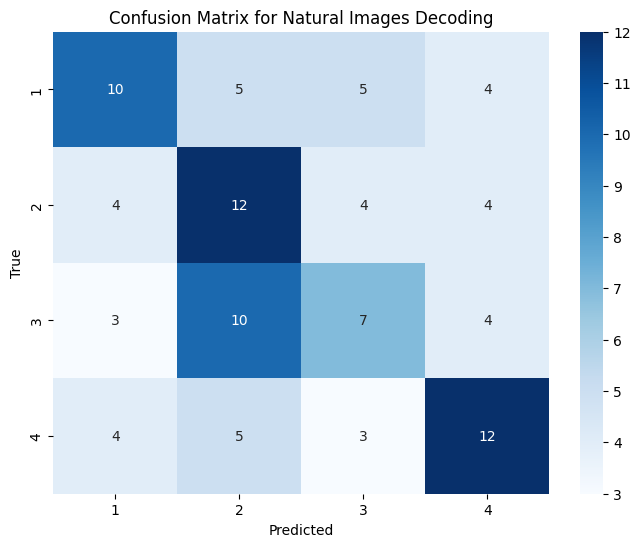

In [62]:
## confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, num_splits+1), yticklabels=range(1, num_splits+1))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Natural Images Decoding')